<a href="https://colab.research.google.com/github/teerasitk/01205415/blob/main/TradeSimulationARCHARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install
1. yfinance for accessing yahoo finance data
2. tensortrade for trade simulation

In [1]:
!pip install yfinance # download data from yahoo finance
!pip install tensortrade # trade simulation
!pip install arch # ARCH and GARCH model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.6/32.6 MB 25.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.9 MB/s eta 0:00:00
  Created wheel for tensortrade: filename=tensortrade-1.0.3-py3-none-any.whl size=134844 sha256=2f22b2570ef712e359679c02993a0c19acee72a267ab02abad3f3e7009a118a4
  Stored in directory: /root/.cache/pip/wheels/7f/a7/75/792c00b8bcd136448db22cd2ca4b4bf0856a58a7dea881bcfc
Successfully built tensortrade
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 6.1 MB/s eta 0:00:00


# import Python libraries

In [2]:
import yfinance as yf # api for yahoo finance
import pandas as pd # mange dataframe
import numpy as np # array computation
import matplotlib.pyplot as plt # plot graph
import arch  # ARCH and GARCH model

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


# Download AOT from 2015 to 2023



In [3]:
data_frame = yf.download("AOT.BK", "2015-01-01", "2023-12-31")
data_frame.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-05,28.0,28.000000,27.200001,27.299999,24.920395,24970000
2015-01-06,26.9,27.400000,26.700001,27.200001,24.829109,24309000
2015-01-07,27.5,28.299999,27.500000,28.299999,25.833227,20682000
2015-01-08,28.9,29.000000,28.600000,28.900000,26.380930,23039000
2015-01-09,29.1,29.299999,28.900000,29.100000,26.563498,34221000


# Develop ARMA + GARCH Model

# ARMA tools

In [4]:
import itertools    # for looping over all possible p and q
import warnings # disable warning
import statsmodels.tsa.arima.model as arima_model # main arma model
warnings.simplefilter("ignore") # ignorall warning

def armaParameterSearch(data:pd.Series,
                        ar_order:int,
                        ma_order:int): #
  p = range(ar_order + 1) # 0,..., ar_oder
  q = range(ma_order + 1) # 0, ... , ma_order
  parameter_spaces = list(itertools.product(p,q)) # pairs of all possible values
  best_aic, pq, best_result = None, None, None # initilize to None
  for (p,  q) in parameter_spaces: # all p,q pairs
    try :
      model = arima_model.ARIMA(data, order=(p,0,q), trend="c") # constant Trend
      result = model.fit() # fit with data
      if (best_aic is None) or (result.aic < best_aic):
        # if better aic
        best_aic = result.aic
        pq = (p,q)
        best_result = result
    except:
      continue
  return best_aic, pq, best_result


p-value: 0.0000


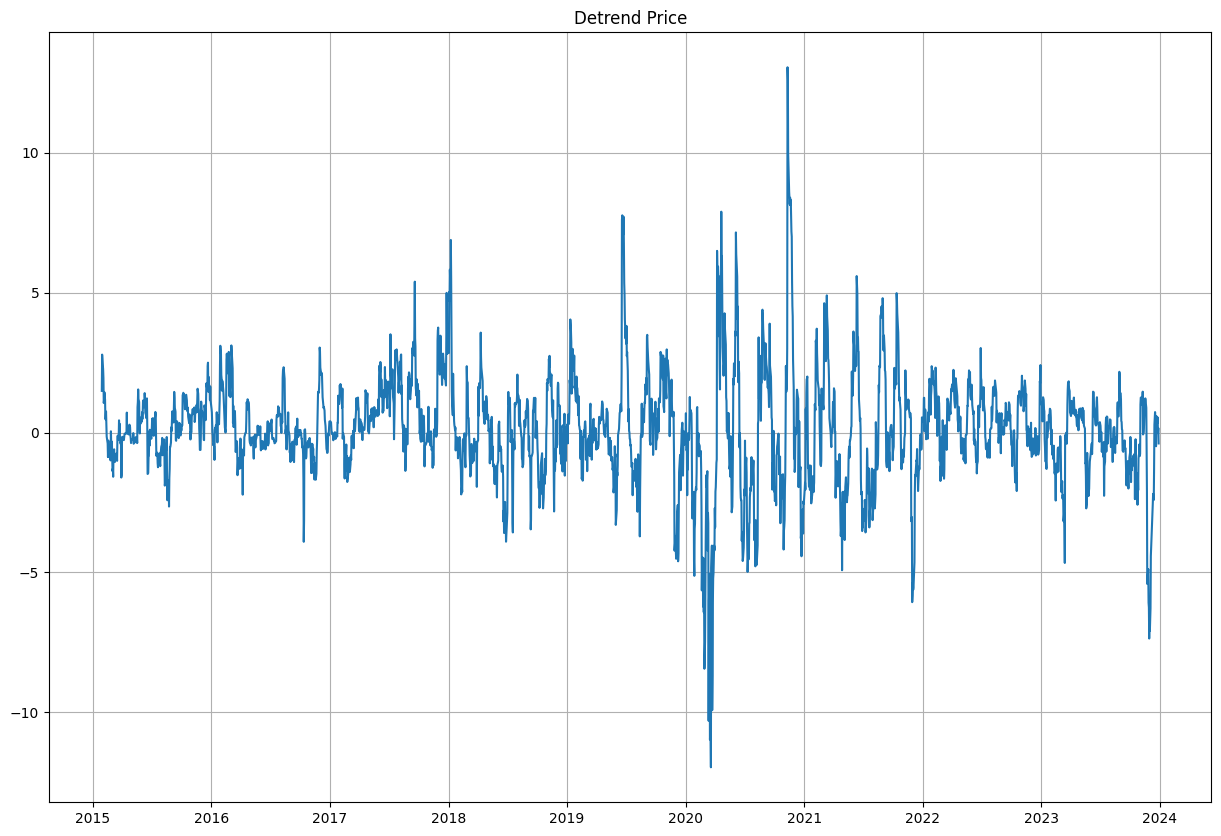

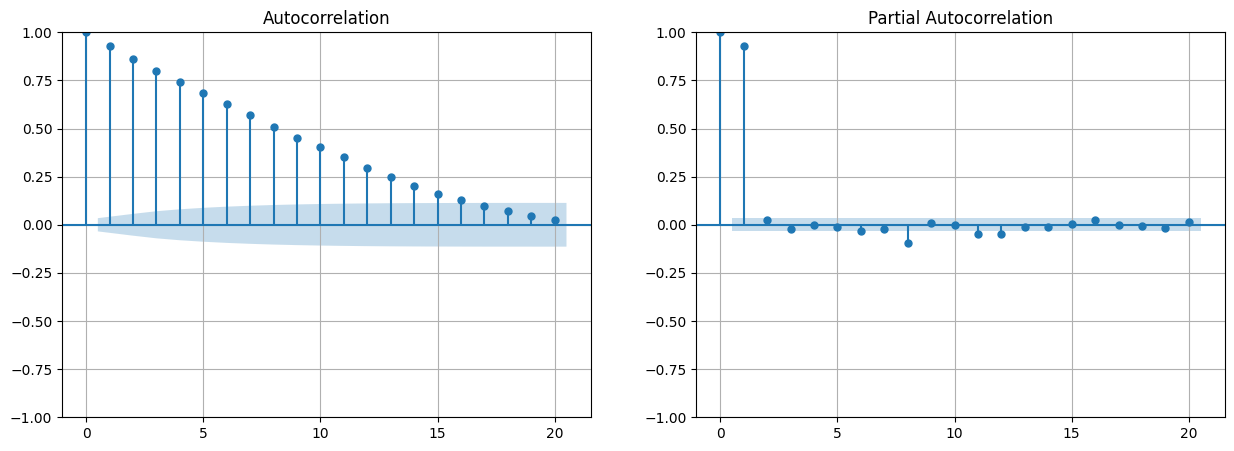

In [6]:
from statsmodels.tsa.stattools import adfuller # test for stationary
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # plot acf and pacf
aot_price = data_frame.Close # use close prices
aot_price = aot_price.resample("1d").ffill() # fill all holidays
moving_avg = aot_price.rolling(25).mean() # 25-days moving average
detrend = aot_price - moving_avg# detrend by 25 days moving average
detrend = detrend.dropna() # drop NaN out
adf, p_val, *_ = adfuller(detrend)
print(f"p-value: {p_val:0.4f}") # is p-value small enough?

fig = plt.figure(figsize=(15,10)) # plot graphs
plt.plot(detrend) # detrend
plt.grid()
plt.title(r"Detrend Price")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5)) # subplot 2 x 1
plot_acf(x=detrend,ax=axes[0], lags=20) # top for acf
axes[0].grid()
plot_pacf(x=detrend,ax=axes[1], lags=20) # bottom for pacf
axes[1].grid()

# determine best ARMA model

In [7]:
# searching for p = 0,...,3 and q = 0,..., 3
aic, pq, best_result = armaParameterSearch(data=detrend,
                                           ar_order=3,
                                           ma_order=3)
pq

(3, 1)

In [8]:
print(best_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3256
Model:                 ARIMA(3, 0, 1)   Log Likelihood               -3551.646
Date:                Tue, 30 Jan 2024   AIC                           7115.293
Time:                        01:40:06   BIC                           7151.822
Sample:                    01-29-2015   HQIC                          7128.378
                         - 12-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1162      0.124      0.936      0.349      -0.127       0.360
ar.L1          1.8397      0.025     74.333      0.000       1.791       1.888
ar.L2         -0.7954      0.036    -22.319      0.0

#ARCH model

# determing GARCH and ARCH seach orders

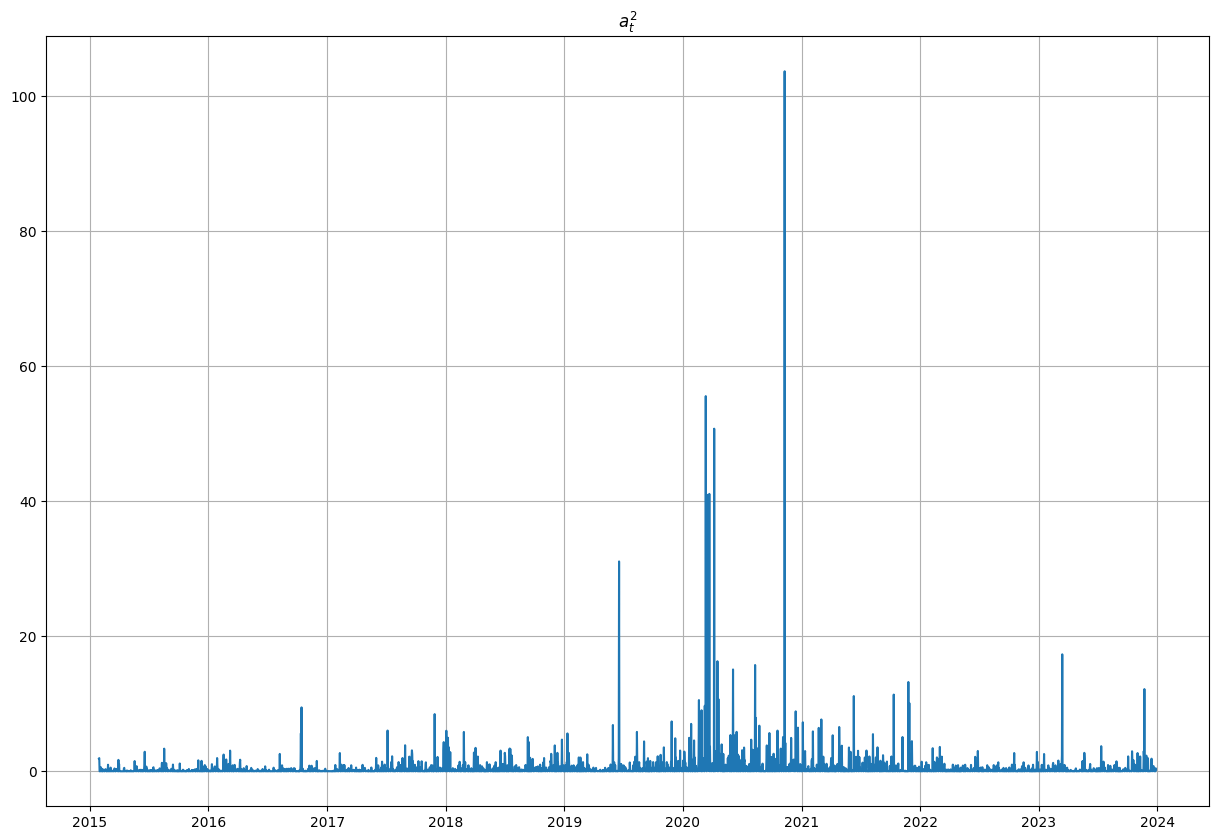

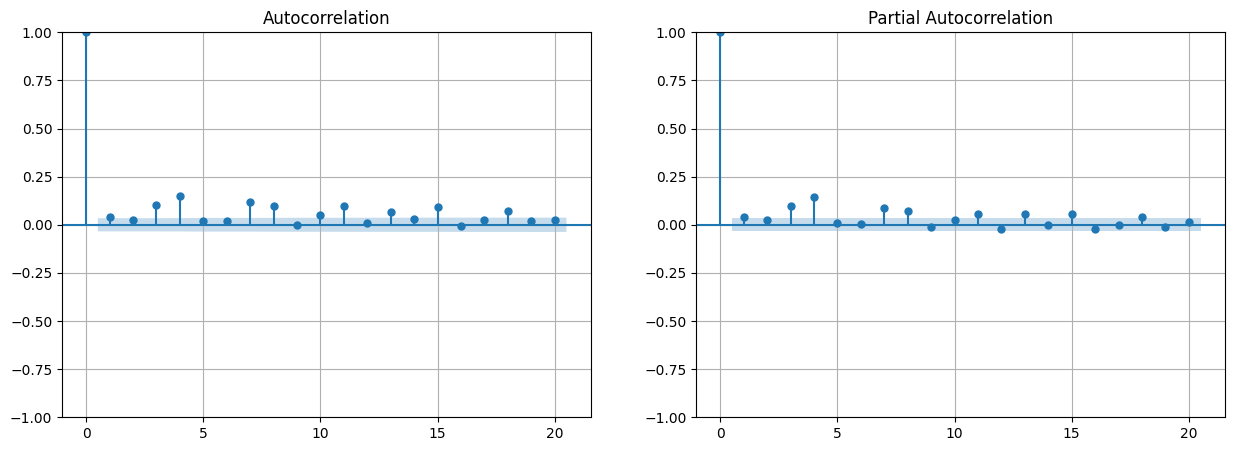

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
a_t = best_result.resid # get residual prices
a_sq = (a_t) ** 2 # compute residual square
fig = plt.figure(figsize=(15,10))
plt.plot(a_sq)
plt.grid()
plt.title(r"$a^2_t$")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plot_acf(x=a_sq,ax=axes[0], lags=20)
axes[0].grid()
plot_pacf(x=a_sq,ax=axes[1], lags=20)
axes[1].grid()


It seems to have vanish after 5 steps.

In [10]:
# GARCH parameter search
def buildGARCH(a_t, # noise
               p_max, # max a_t
               q_max,  # max sigma_t
               split_date=None # date for the last observation
               ):
  best_aic = np.inf # start at aic = infinity
  best_result, best_model, pq = None, None, None
  for p in range(1, p_max + 1): # p = 1,..,p_max
    for q in range(0, q_max +1): # q= 0,...,q_max
      model = arch.arch_model(y=a_t, # noise
                              mean="constant", #constant mean
                              p=p,
                              q=q,
                              vol="GARCH") # use garch model
      try:
        if split_date is not None: # if there is the last observation
          result = model.fit(disp=False, last_obs=split_date)
        else:
          result = model.fit(disp=False)
        aic = result.aic
        if aic < best_aic: # better aic?
          best_aic = aic
          pq = (p,q)
          best_result = result
          best_model = model
      except:
        print(f"Cannot fit GARCH for p={p}, q={q}!!")
  return pq, best_result, best_model

In [11]:
garch_pq, garch_result, garch_model = buildGARCH(a_t,
                                                 p_max=5,
                                                 q_max=5)
print(f"Best garch model: {garch_pq}")

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Best garch model: (1, 5)


In [12]:
print(garch_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3053.75
Distribution:                  Normal   AIC:                           6123.49
Method:            Maximum Likelihood   BIC:                           6172.20
                                        No. Observations:                 3256
Date:                Tue, Jan 30 2024   Df Residuals:                     3255
Time:                        01:40:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.4090e-03  9.792e-03      0.859      0.390 

# The proposed mean model: ARMA(3,1), Vol: GARCH(1,5)


# Build Trade Environment

In [13]:
import tensortrade.env.default as default
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.instruments import Instrument
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.exchanges import Exchange, ExchangeOptions
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger

# Building symbols & Market

In [14]:
THB = Instrument(symbol="THB", precision=2, name="Thai Baht")
AOT = Instrument(symbol="AOT", precision=2, name="Airports of Thailand")
set_market = Exchange("set", service=execute_order,
                      options=ExchangeOptions(commission=0.0001))
# build exchange market
# commission is to 0.01%
buy_sell_prices = data_frame['Close'].tolist()
stream_prices = Stream.source(buy_sell_prices, dtype='float').rename("THB-AOT")
set_market = set_market(stream_prices)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# building Features

In [16]:
hist_len = 90 # look back 1 quarter
dataframe_feats = pd.DataFrame()
dataframe_feats["detrend"] = detrend # for ARMA and GARCH
dataframe_feats["moving_avg"] = moving_avg # change back to data
dataframe_feats["Close"] = aot_price
dataframe_feats["High"] = data_frame["High"] # today high
dataframe_feats["Low"] = data_frame["Low"] # today low
dataframe_feats = dataframe_feats.dropna() # drop NaN out
dataframe_feats.head()

,detrend,moving_avg,Close,High,Low
Date,,,,,
2015-01-29,1.488000,29.412,30.900000,31.200001,30.500000
2015-01-30,2.784002,29.616,32.400002,32.400002,31.000000
2015-02-02,2.272001,30.128,32.400002,32.400002,31.600000
2015-02-03,1.948001,30.252,32.200001,33.299999,32.200001
2015-02-04,1.055999,30.344,31.400000,32.500000,31.400000


In [17]:
streams = [Stream.source(
    dataframe_feats["detrend"].shift(c)).rename(f"detrend_lag{c:02d}")
    for c in range(1, hist_len+1)]
streams.append(Stream.source(dataframe_feats["moving_avg"].shift(1), # yesterday MA(25)
                         dtype="float").rename("moving_avg"))
streams.append(Stream.source(dataframe_feats["Close"],
                         dtype="float").rename("Close"))
streams.append(Stream.source(dataframe_feats["High"],
                         dtype="float").rename("max_of_day"))
streams.append(Stream.source(dataframe_feats["Low"],
                         dtype="float").rename("min_of_day"))

In [21]:
feed = DataFeed(streams)
feed.next()

{'detrend_lag01': nan,
 'detrend_lag02': nan,
 'detrend_lag03': nan,
 'detrend_lag04': nan,
 'detrend_lag05': nan,
 'detrend_lag06': nan,
 'detrend_lag07': nan,
 'detrend_lag08': nan,
 'detrend_lag09': nan,
 'detrend_lag10': nan,
 'detrend_lag11': nan,
 'detrend_lag12': nan,
 'detrend_lag13': nan,
 'detrend_lag14': nan,
 'detrend_lag15': nan,
 'detrend_lag16': nan,
 'detrend_lag17': nan,
 'detrend_lag18': nan,
 'detrend_lag19': nan,
 'detrend_lag20': nan,
 'detrend_lag21': nan,
 'detrend_lag22': nan,
 'detrend_lag23': nan,
 'detrend_lag24': nan,
 'detrend_lag25': nan,
 'detrend_lag26': nan,
 'detrend_lag27': nan,
 'detrend_lag28': nan,
 'detrend_lag29': nan,
 'detrend_lag30': nan,
 'detrend_lag31': nan,
 'detrend_lag32': nan,
 'detrend_lag33': nan,
 'detrend_lag34': nan,
 'detrend_lag35': nan,
 'detrend_lag36': nan,
 'detrend_lag37': nan,
 'detrend_lag38': nan,
 'detrend_lag39': nan,
 'detrend_lag40': nan,
 'detrend_lag41': nan,
 'detrend_lag42': nan,
 'detrend_lag43': nan,
 'detrend_l

# Initialize portfolio with 100k THB and 0 Shares of AOT

In [22]:
cash = Wallet(set_market, 100_000 * THB) # initialize at 100k THB
asset = Wallet(set_market, 0 * AOT)
portfolio = Portfolio(THB, [cash,
                            asset])

In [23]:
portfolio.balances

[100000.00 THB, 0.00 AOT]

# Build Trading Environment

In [24]:
env = default.create(
        portfolio=portfolio, # start with our portfolio
        action_scheme=default.actions.BSH(cash=cash, asset=asset), # all in and out
        # I made some changes here
        reward_scheme=default.rewards.SimpleProfit(), # simple profit (to be used later)
        feed=feed, # data feed for historical price
        window_size=1, # historical data that we need
        min_periods=hist_len # starting trading location
        )


# Build a trading strategies
Here, we buy if upper confidence interval is lower than the max price of the day, and sell if lower confidence interval is high than the max price

In [25]:
from scipy.stats import norm
done = False
obs = env.reset() # reset environment move to the first ate
cnt = 0
actions = [0] # first action no hold
status = "No Position"
p,q= pq # ARMA orders
arch_p, arch_q = garch_pq # GARCH orders
alpha = 0.05 # significance level at 5%
action = 0
while not done: # loop until all data are exhausted
  detrend_price  = obs[0][:hist_len] # historical detrend data
  last_moving_avg = obs[0][hist_len] # last 25-days moving average
  close_price = obs[0][hist_len + 1 ] # close price
  max_day = obs[0][hist_len + 2] # today maximum price
  min_day = obs[0][-1] # today low price
  arma_model = arima_model.ARIMA(detrend_price, order=(p,0,q), trend="t")
  # fit ARMA with linear trend (constant trend gives errors)
  arma_result = arma_model.fit()
  a_t =  arma_result.resid # obtain residual
  garch_model = arch.arch_model(y=a_t, mean="constant", p=arch_p,
                                q=arch_q, vol="GARCH")
  garch_result = garch_model.fit(disp=False) # fit GARCH model

  forecast = arma_result.get_forecast(steps=1) # forecast of y_t (detrend)
  next_val = forecast.predicted_mean[0] # y_hat t
  grach_forecast = garch_result.forecast(horizon=1)
  vol = np.sqrt(grach_forecast.variance["h.1"].iloc[0]) # forecast vol for a_t
  lower_conf = next_val - vol*norm.ppf(1 - alpha/2.0) # lower confidence interval
  upper_conf = next_val + vol*norm.ppf(1 - alpha/2.0) # upper confidence interval
  # end of the day price = MA(25)_t + y_hat_t
  forcasted_upper_price = upper_conf + last_moving_avg
  forcasted_lower_price = lower_conf + last_moving_avg
  if (status == "No Position") and (forcasted_upper_price < max_day):
    # no position and today price exceeds the forecast upper bound
    action = 1 # all in
    status = "Hold"
  elif (status == "Hold") and (forcasted_lower_price > min_day):
    # hold asset and today price breaks the forecast lower bound
    action = 0 # all out
    status = "No Position"
  else:
    pass
  #action = env3.action_space
  actions.append(action) # keep all action
  obs, reward, done, info = env.step(action) # perform trading
  print(info, portfolio.balances)
portfolio.ledger.as_frame().head(7)

{'step': 1, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 2, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 3, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 4, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 5, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 6, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 7, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 8, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 9, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 10, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 11, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 12, 'net_worth': 100000.0} [100000.00 THB, 0.00 AOT]
{'step': 13, 'net_worth': 100639.33} [0.00 THB, 3246.43 AOT]
{'step': 14, 'net_worth': 102262.545} [0.00 THB, 3246.43 AOT]
{'step': 15, 'net_worth': 101937.90076158523} [0.00 THB, 3246.43 AOT]
{'step': 16, 'net_worth': 100639.33} [0.00 THB, 3246.43 AOT]
{'step': 17

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


{'step': 1058, 'net_worth': 170284.065} [0.00 THB, 2316.79 AOT]
{'step': 1059, 'net_worth': 171442.46} [0.00 THB, 2316.79 AOT]
{'step': 1060, 'net_worth': 171442.46} [0.00 THB, 2316.79 AOT]
{'step': 1061, 'net_worth': 170863.2625} [0.00 THB, 2316.79 AOT]
{'step': 1062, 'net_worth': 167967.275} [0.00 THB, 2316.79 AOT]
{'step': 1063, 'net_worth': 169125.66999999998} [0.00 THB, 2316.79 AOT]
{'step': 1064, 'net_worth': 170863.2625} [0.00 THB, 2316.79 AOT]
{'step': 1065, 'net_worth': 170863.2625} [0.00 THB, 2316.79 AOT]
{'step': 1066, 'net_worth': 172021.6575} [0.00 THB, 2316.79 AOT]
{'step': 1067, 'net_worth': 173180.0525} [0.00 THB, 2316.79 AOT]
{'step': 1068, 'net_worth': 172021.6575} [0.00 THB, 2316.79 AOT]
{'step': 1069, 'net_worth': 169125.66999999998} [0.00 THB, 2316.79 AOT]
{'step': 1070, 'net_worth': 169108.88} [169108.88 THB, 0.00 AOT]
{'step': 1071, 'net_worth': 169108.88} [169108.88 THB, 0.00 AOT]
{'step': 1072, 'net_worth': 169108.88} [169108.88 THB, 0.00 AOT]
{'step': 1073, 'n

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


{'step': 1540, 'net_worth': 161626.5225} [0.00 THB, 2596.41 AOT]
{'step': 1541, 'net_worth': 160328.3175} [0.00 THB, 2596.41 AOT]
{'step': 1542, 'net_worth': 161626.5225} [0.00 THB, 2596.41 AOT]
{'step': 1543, 'net_worth': 160328.3175} [0.00 THB, 2596.41 AOT]
{'step': 1544, 'net_worth': 158381.00999999998} [0.00 THB, 2596.41 AOT]
{'step': 1545, 'net_worth': 161626.5225} [0.00 THB, 2596.41 AOT]
{'step': 1546, 'net_worth': 161626.5225} [0.00 THB, 2596.41 AOT]
{'step': 1547, 'net_worth': 162275.625} [0.00 THB, 2596.41 AOT]
{'step': 1548, 'net_worth': 161626.5225} [0.00 THB, 2596.41 AOT]
{'step': 1549, 'net_worth': 161610.34} [161610.34 THB, 0.00 AOT]
{'step': 1550, 'net_worth': 161610.34} [161610.34 THB, 0.00 AOT]
{'step': 1551, 'net_worth': 161610.34} [161610.34 THB, 0.00 AOT]
{'step': 1552, 'net_worth': 161610.34} [161610.34 THB, 0.00 AOT]
{'step': 1553, 'net_worth': 161610.34} [161610.34 THB, 0.00 AOT]
{'step': 1554, 'net_worth': 161610.34} [161610.34 THB, 0.00 AOT]
{'step': 1555, 'net

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,aad751b1-360e-4994-a779-d222b3074a3e,13,set:THB/free,set:THB/locked,LOCK (LOCK FOR ORDER),100000.00 THB,0.00 THB,100000.00 THB,100000.00 THB
1,aad751b1-360e-4994-a779-d222b3074a3e,13,set:THB/locked,set,WITHDRAWAL (COMMISSION),10.00 THB,0.00 THB,99990.00 THB,99990.00 THB
2,aad751b1-360e-4994-a779-d222b3074a3e,13,set:THB/locked,set,WITHDRAWAL (FILL ORDER),99990.00 THB,0.00 THB,0.00 THB,0.00 THB
3,aad751b1-360e-4994-a779-d222b3074a3e,13,set,set:AOT/locked,DEPOSIT (TRADED 99990.00 THB set:THB/AOT @ 30.80),3246.43 AOT,0.00 AOT,3246.43 AOT,3246.43 AOT
4,aad751b1-360e-4994-a779-d222b3074a3e,13,set:THB/locked,set:THB/free,UNLOCK THB (COMPLETED),0.00 THB,0.00 THB,0.00 THB,0.00 THB
5,aad751b1-360e-4994-a779-d222b3074a3e,13,set:AOT/locked,set:AOT/free,UNLOCK AOT (COMPLETED),3246.43 AOT,3246.43 AOT,0.00 AOT,0.00 AOT
6,9a115af6-5895-4cdd-9bcd-902dd0d0c8c4,26,set:AOT/free,set:AOT/locked,LOCK (LOCK FOR ORDER),3246.43 AOT,0.00 AOT,3246.43 AOT,3246.43 AOT


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


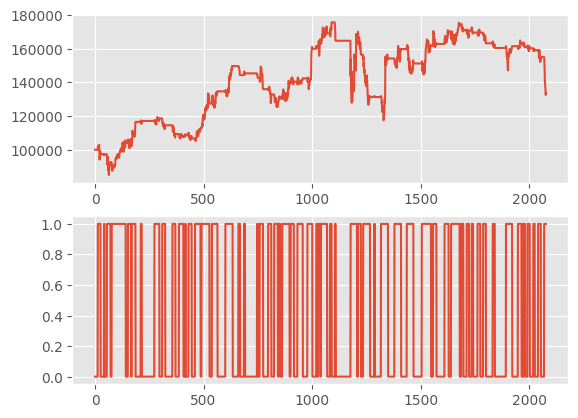

In [26]:
df = pd.DataFrame(portfolio.performance) # convert profolio performance to dataframe
df = df.T
plt.subplot(2,1,1)
plt.plot(df.net_worth) # plot networths
plt.subplot(2,1,2)
plt.plot(actions) # plot actions

In [27]:
print(f"{df.net_worth.iloc[-1]:,.2f}") # last net worth

133,673.30


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
ret = df.net_worth.pct_change(1).dropna()
sharp_ration = ret.mean() / ret.std() #compute sharpe ratio
print(f"Sharp ratio: {sharp_ration *np.sqrt(365):0.3f}")

Sharp ratio: 0.329


# Buy and Hold Strategy

In [30]:
cash = Wallet(set_market, 100_000 * THB)
asset = Wallet(set_market, 0 * AOT)
portfolio2 = Portfolio(THB, [cash,
                            asset])
env2 = default.create(
        portfolio=portfolio2, # start with our portfolio
        action_scheme=default.actions.BSH(cash=cash, asset=asset), # all in or out
        # I changed from simple order to BUY-SELL Order
        reward_scheme=default.rewards.SimpleProfit(), # simple profit (to be used later)
        feed=feed, # data feed for historical price
        window_size=1, # historical data that we need
        min_periods=hist_len # starting trading location
        )
portfolio2.balances

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[100000.00 THB, 0.00 AOT]

In [31]:
done = False
obs = env2.reset()
cnt = 0
actions_buyhold = [0]
action = 1
while not done:
  actions.append(action)
  obs, reward, done, info = env2.step(action)
  action = 1
  actions_buyhold.append(action)
portfolio2.ledger.as_frame().head(7)

,poid,step,source,target,memo,amount,free,locked,locked_poid
0,0a938f17-e0c7-4fcd-affa-1ca4d0cd732e,1,set:THB/free,set:THB/locked,LOCK (LOCK FOR ORDER),100000.00 THB,0.00 THB,100000.00 THB,100000.00 THB
1,0a938f17-e0c7-4fcd-affa-1ca4d0cd732e,1,set:THB/locked,set,WITHDRAWAL (COMMISSION),10.00 THB,0.00 THB,99990.00 THB,99990.00 THB
2,0a938f17-e0c7-4fcd-affa-1ca4d0cd732e,1,set:THB/locked,set,WITHDRAWAL (FILL ORDER),99990.00 THB,0.00 THB,0.00 THB,0.00 THB
3,0a938f17-e0c7-4fcd-affa-1ca4d0cd732e,1,set,set:AOT/locked,DEPOSIT (TRADED 99990.00 THB set:THB/AOT @ 30.10),3321.93 AOT,0.00 AOT,3321.93 AOT,3321.93 AOT
4,0a938f17-e0c7-4fcd-affa-1ca4d0cd732e,1,set:THB/locked,set:THB/free,UNLOCK THB (COMPLETED),0.00 THB,0.00 THB,0.00 THB,0.00 THB
5,0a938f17-e0c7-4fcd-affa-1ca4d0cd732e,1,set:AOT/locked,set:AOT/free,UNLOCK AOT (COMPLETED),3321.93 AOT,3321.93 AOT,0.00 AOT,0.00 AOT


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


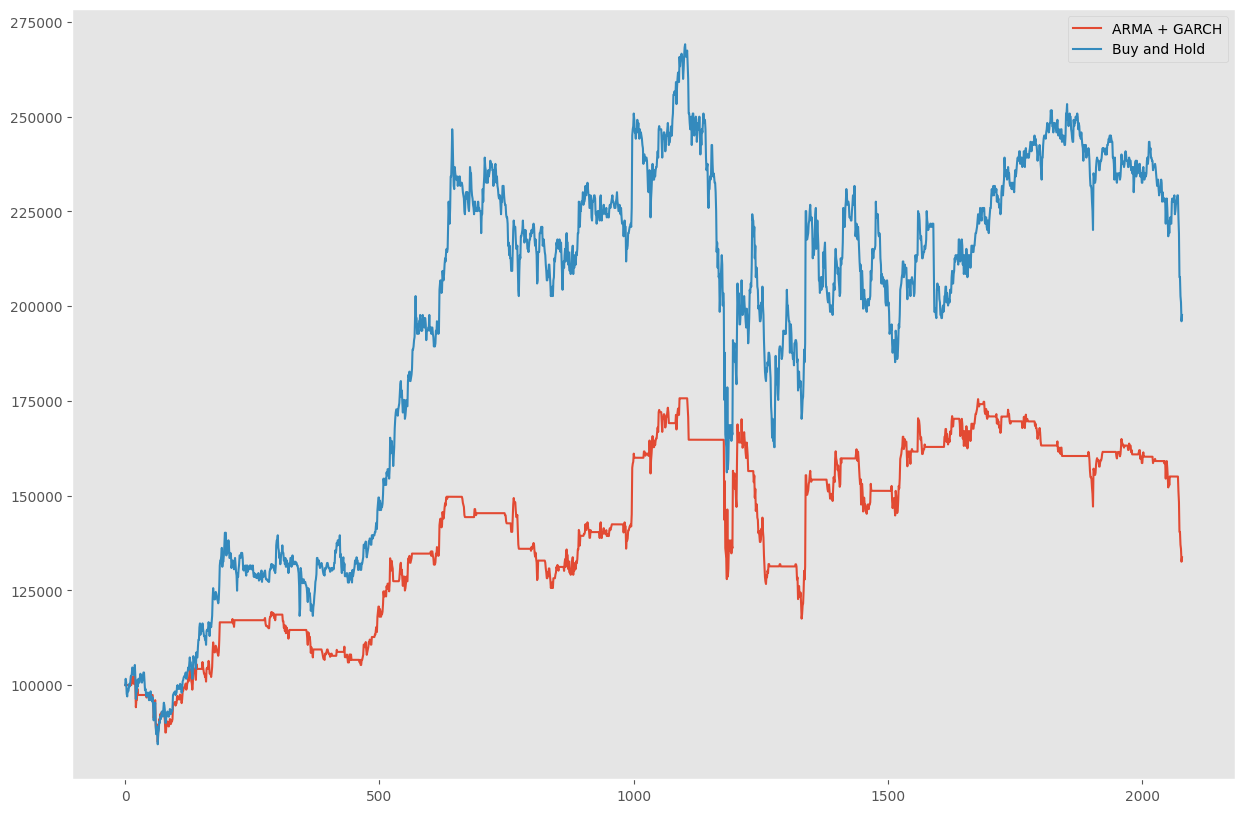

In [32]:
df2 = pd.DataFrame(portfolio2.performance)
df2 = df2.T
plt.figure(figsize=(15,10))
plt.plot(df.net_worth, label="ARMA + GARCH")
plt.plot(df2.net_worth, label="Buy and Hold")
plt.legend()
plt.grid()

In [33]:
ret2 = df2.net_worth.pct_change(1).dropna()
sharpe_ration_buy_hold = ret2.mean() / ret2.std() #compute sharpe ratio
print(f"Sharpe ratio ")
print(f"    ARMA + GARCH {sharp_ration *np.sqrt(365):0.3f}")
print(f"    Buy and Hold :{sharpe_ration_buy_hold*np.sqrt(365):0.3f}")

Sharpe ratio 
    ARMA + GARCH 0.329
    Buy and Hold :0.537


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
